In [51]:
from IPython.display import HTML,display,Markdown

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this document is by default hidden.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import tensorflow as tf
import time
import numpy as np
import scipy as sp

## Keras ##
import keras
import keras.backend as KK ##Keras backend usually tensorflow ##
from keras.datasets import cifar10 
from matplotlib import pyplot as plt
from keras.utils import np_utils
import keras.callbacks as cb
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.layers.advanced_activations import ELU

from scipy import stats

import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import sklearn as sk
import string
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Figure, Layout
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import datetime as dt
import os,sys
import functools
from scipy.optimize import brenth

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import gc
import copy

##############################################
### rpy2 ###

import rpy2.robjects.numpy2ri
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector, Formula

rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()


## Generates an interactive plotly plot ##
"""
Inputs:
   names: a list of strings for the legend.
   dates: a pandas time-series or numpy vector for the x-axis.
   Jupyter: A boolean: is this function called in a jupyter notebook ?
   Other args: pandas ts or numpy vectors of the data to plot. Must be the
   same length as names.
   
Outputs:
    an html page with the plotly graph on it.
   
e.g. plotly_plot(["real","estim"],evaluation.dates,False,Y_eval,Y_hat)
"""
def plotly_plot(names,dates,Jupyter=False,*args):
    n = len(args)
    traces = []
    
    if n == 0:
        sys.exit("Error - provide argument")
    
    for k in range(n):
        traces.append(
        go.Scatter(
    x = dates,
    y = np.asarray(args[k]),
    mode = 'lines',
    name = names[k] )        
    )
        
    if Jupyter==True:
        plotly.offline.iplot(traces)
    else:
        plot(traces, filename='pltly_plot')

## Generate a learning, validation and evaluation set  ###
"""
Inputs:
   df : a pandas dataframe.
   p_1: a float between 0 and 1 giving the proportion used for learning.
   p_2: a float between p_1 and 1. The proportion p_2 - p_1 is then used
   to construct the validation set.
    
Outputs:
   a tuple of pandas dataframes corresponding to the learning, valid and eval
   sets.
   
e.g. generate_sets(df,0.6,0.8) corresp. to 60% for learning, 20% for
validation and 20% for evaluation.
    
"""

def generate_sets(df,p_1=0.6,p_2=0.8):
    
    N = df.shape[0]
    
    if p_1 > p_2:
        sys.exit("Error : p_1 must be greater than p_2")
    
    elif p_1 == p_2:
        indices_L = np.array(range(0,int(p_1*N)))
        indices_E = np.array(range(int(p_1*N),N))
        
        learning = df.iloc[indices_L]
        evalu = df.iloc[indices_E]
        
        to_return = (learning,evalu)
    else:
        indices_L = np.array(range(0,int(p_1*N)))
        indices_V = np.array(range(int(p_1*N),int(p_2*N)))
        indices_E = np.array(range(int(p_2*N),N))
        
        learning = df.iloc[indices_L]
        valid = df.iloc[indices_V]
        evalu = df.iloc[indices_E]

        to_return = (learning,valid,evalu)
    
    return to_return

### A variant of the previous functions where the sets are build by
### "consecutive blocks" of data.

""" 
Inputs:
    df: a pandas dataframe
    n_learn: an integer of consecutive samples for one learning block.
    n_valid: the same for the validation set.
    n_eval: the same for the evaluation set.
    
Outputs: a tuple of pandas dataframes.

e.g. generate_sets_2(df,300,100,100) again corresp to a 60/20/20 split.
However this time the sets are built as following: 300 samples are added to the
learning, 100 to valid, 100 to eval, then again 300 to learning, and so on...

"""

def generate_sets_2(df,n_learn=300,n_valid=100,n_eval=100):
    
    N = df.shape[0]
    
    ## Remaining data points
    remaining = N
    
    ## Size of a "chunck" of data
    tot_block = n_learn+n_valid+n_eval
    
    ## Fraction of datafor each set  ##
    
    frac_L = n_learn/tot_block
    frac_V = frac_L + n_valid/tot_block
    frac_E = frac_V + n_eval/tot_block
    
    ## Init of indices ##
    indices_L = np.array([False]*N)
    indices_V = np.array([False]*N)
    indices_E = np.array([False]*N)
    
    current_ind = np.arange(0,tot_block,1)
    
    while(remaining >tot_block):
        indices_L[current_ind[:n_learn]] = True
        indices_V[current_ind[n_learn:(n_learn+n_valid)]] = True
        indices_E[current_ind[(n_learn+n_valid):tot_block]] = True
        
        current_ind += tot_block
        
        remaining -= tot_block
        
    
    indices_L[current_ind[:int(frac_L*remaining)]] = True
    indices_V[current_ind[int(frac_L*remaining):int(frac_V*remaining)]] = True
    indices_E[current_ind[int(frac_V*remaining):int(frac_E*remaining)]] = True
    
    ## Preparation of the datasets ##
    if(type(df)==pd.core.frame.DataFrame):
        learning = df.iloc[indices_L]
        valid = df.iloc[indices_V]
        evalu = df.iloc[indices_E]
        
    elif(type(df)==np.ndarray):
        learning = df[indices_L,:,:,:]
        valid = df[indices_V,:,:,:]
        evalu = df[indices_E,:,:,:]

    to_return = (learning,valid,evalu)
    
    return to_return

## Prepares a numpy array for Keras convolution layer ##
def CNN_prep(df,*args):
    """
    Inputs: 
        df: a pandas dataframe or numpy 2D array from which the CNN data will be built.
        Other arguments: must be provided exclusively if df is a pandas df.
        Then provide a list of strings corresponding to the names of the variables
        of the df which should be kept.
        
    Returns: a 4D numpy array suitable for the Keras convo layer.
    
    e.g. CNN_prep(learning,["ws1_1,"ws_angle1_1","wd1_1"])
    
    """
    N = df.shape[0]
    n_channels = len(args)
    p = len(args[0])
        
    df_CNN = np.zeros((N,4,p,n_channels))
    
    if(type(df)==pd.core.frame.DataFrame):
        for k in range(n_channels):
            for t in range(N):
                if t in np.arange(0,3):
                    X = np.asarray(df[args[k]].iloc[np.arange(0,t+1)])
                    X = np.concatenate((np.zeros((3-t,p)),X))
                    df_CNN[t,:,0:p,k] = X     
                
                else:
                    df_CNN[t,:,0:p,k] = np.asarray(df[args[k]].iloc[np.arange(t-3,t+1)])
        
    elif(type(df)==np.ndarray):
        for t in range(N):
            if t in np.arange(0,3):
                X = df[np.arange(0,t+1),:]
                X = np.concatenate((np.zeros((3-t,df.shape[1])),X))
                df_CNN[t,:,0:df.shape[1],0] = X     
                
            else:
                df_CNN[t,:,0:df.shape[1],0] = df[np.arange(t-3,t+1),:]
        
    
    return df_CNN

## Function to build a Keras neural network ##
def call_NN(hn,p,activ,bound,n_inp,n_out,mode,activ_c=None,filters=None,kernel=None,channels=1):
    """
    Inputs:
       hn : a list of integers with the number of hidden neurons per layer
       p : a list of floats giving the dropout probability for each layer
       activ : a list of strings giving the activ. functions used for every layer.
One must add the backend in front of tanh, relu, linear or other 'classic' activations.
Special activations (such as ELU) don't need this.
       bound: bound for the uniform weight initialization.
       n_inp: an integer giving the number of inputs to the network.
       n_out: an integer giving the number of outputs of the network.
       mode: a string, either "ANN" or "CNN" to indicate if a regular MLP
       or CNN is used.
       activ_c: a string giving the name of the activation used for the convo
       layer
       filters: an integer giving the number of filters used for convolution.
       kernel: a tuple of two integers giving the size of the kernel.
       channels: an integer giving the number of channels of the input 'image'.
       
    Outputs: 
        A compiled Keras model object ready to be fitted.
       
e.g. for a two hidden-layer MLP with tanh as activation and KK being the backend of Keras:
    hn = [20,50]
    p = [0,0.1,0]
    activ = ["KK.tanh","KK.tanh","KK.tanh"] """
    
    n_hidden = len(hn)
    
    model = Sequential()
    
    ## Regular MLP ##
    if mode == "ANN":
        if(p[0] !=0):
            model.add(Dropout(p[0],input_shape=(n_inp,)))
            model.add(Dense(hn[0], 
               bias_initializer='zeros',
               kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound),
               kernel_constraint=maxnorm(4.5)))
            if activ[0] != "linear":
                model.add(Activation(eval(activ[0])))
        else:
            model.add(Dense(hn[0], input_dim=n_inp,
               bias_initializer='zeros',
               kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound)))
            if activ[0] != "linear":
                model.add(Activation(eval(activ[0])))
            
        for m in range(1,n_hidden):
            model.add(Dropout(p[m]))
            model.add(Dense(hn[m], ##HL 1 ##
               bias_initializer='zeros',
               kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound),
               kernel_constraint=maxnorm(4.5)))
            if activ[m] != "linear":
                model.add(Activation(eval(activ[m])))
            
        model.add(Dropout(p[n_hidden]))
        
    ## Convolutional NN ## 
    if mode == "CNN":
        model.add(Conv2D(filters=filters,kernel_size=kernel,
            input_shape=(4,n_inp,channels)))
        if activ_c != "linear":
            model.add(Activation(eval(activ_c)))
        model.add(Flatten())  ## No pooling since decreases accuracy
        
        for m in range(n_hidden):
            if m==0:
                model.add(Dropout(p[m]))
                model.add(Dense(hn[m], ##HL 1 ##
                   bias_initializer='zeros',
                   kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound),
                   kernel_constraint=maxnorm(4.5)))
                if activ[0]!="linear":
                    model.add(Activation(eval(activ[0])))
                
            else:
                model.add(Dropout(p[m]))
                model.add(Dense(hn[m], ##HL 1 ##
                   bias_initializer='zeros',
                   kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound),
                   kernel_constraint=maxnorm(4.5)))
                if activ[m]!="linear":
                    model.add(Activation(eval(activ[m])))
            
        model.add(Dropout(p[n_hidden]))
     
    ## Output layer and compilation of model ##
    model.add(Dense(n_out,bias_initializer='zeros',
        kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound)))
    if activ[n_hidden] != "linear":
        model.add(Activation(eval(activ[n_hidden])))
    
    model.compile(loss='mean_squared_error', optimizer="adam", metrics=['mse'])
    
    return model

def call_NN_Q(hn,p,activ,bound,n_inp,n_out,mode,Q,activ_c=None,filters=None,kernel=None,channels=1):
    """
    Inputs:
        the same as previously, with exception of an additional input, "Q":
            a float between O and 1 corresponding to the quantile to be estimated.
         
    Output:
        the same as previously.
    """ 
    n_hidden = len(hn)
    
    model = Sequential()
    
    ## Regular MLP ##
    if mode == "ANN":
        if(p[0] !=0):
            model.add(Dropout(p[0],input_shape=(n_inp,)))
            model.add(Dense(hn[0], 
               bias_initializer='zeros',
               kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound),
               kernel_constraint=maxnorm(4.5)))
            if activ[0] != "linear":
                model.add(Activation(eval(activ[0])))
        else:
            model.add(Dense(hn[0], input_dim=n_inp,
               bias_initializer='zeros',
               kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound)))
            if activ[0] != "linear":
                model.add(Activation(eval(activ[0])))
            
        for m in range(1,n_hidden):
            model.add(Dropout(p[m]))
            model.add(Dense(hn[m], ##HL 1 ##
               bias_initializer='zeros',
               kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound),
               kernel_constraint=maxnorm(4.5)))
            if activ[m] != "linear":
                model.add(Activation(eval(activ[m])))
            
        model.add(Dropout(p[n_hidden]))
        
    ## Convolutional NN ## 
    if mode == "CNN":
        model.add(Conv2D(filters=filters,kernel_size=kernel,
            input_shape=(4,n_inp,channels)))
        if activ_c != "linear":
            model.add(Activation(eval(activ_c)))
        model.add(Flatten())  ## No pooling since decreases accuracy
        
        for m in range(n_hidden):
            if m==0:
                model.add(Dropout(p[m]))
                model.add(Dense(hn[m], ##HL 1 ##
                   bias_initializer='zeros',
                   kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound),
                   kernel_constraint=maxnorm(4.5)))
                if activ[0]!="linear":
                    model.add(Activation(eval(activ[0])))
                
            else:
                model.add(Dropout(p[m]))
                model.add(Dense(hn[m], ##HL 1 ##
                   bias_initializer='zeros',
                   kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound),
                   kernel_constraint=maxnorm(4.5)))
                if activ[m]!="linear":
                    model.add(Activation(eval(activ[m])))
            
        model.add(Dropout(p[n_hidden]))
     
    ## Output layer and compilation of model ##
    model.add(Dense(n_out,bias_initializer='zeros',
        kernel_initializer=keras.initializers.RandomUniform(minval=-bound, maxval=bound)))
    if activ[n_hidden] != "linear":
        model.add(Activation(eval(activ[n_hidden])))
    
    model.compile(loss=lambda y,f: tilted_loss(Q,y,f), optimizer='adadelta')
    
    return model

## Pinball loss for quantile regression ##
def tilted_loss(q,y,f):
    e = (y-f)
    # The term inside k.mean is a one line simplification of the first equation
    return KK.mean(q*e + KK.clip(-e, KK.epsilon(), np.inf), axis=-1)


## Functions to calculate the quantiles of a gaussian mixture model ##
"""
Inputs:
   x: a float
   w: a vector of floats corresponding to the mixture coefficients.
   mu: a vector of floats corresponding to the means of the gaussian distrib.
   sd: a vector of floats corresponding to the standard devs of the gauss distrib.
"""

def GMM(x,w,mu,sd):
    N = len(w)
    R = 0
    
    for k in range(N):
        R+= w[k]*stats.norm.cdf(x,mu[k],sd[k])

    return R



def GMM_inv(p,w,mu,sd,br):
     R = np.zeros(w.shape[0])
     
     for t in range(w.shape[0]):
         G = lambda x: GMM(x,w[t,:],mu[t,:],sd[t,:]) - p
         
         R[t] = brenth(G,br[0],br[1])
     
     return R
 

 
def GMM0_inv(p,w,mu,sd,br):
     R = np.zeros(w.shape[0])
     
     for t in range(len(w)):
         G = lambda x: GMM(x,w,mu,sd) - p
         
         R= brenth(G,br[0],br[1])
     
     return R
 
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

Using TensorFlow backend.


In [21]:
## ====== Pandas dataframes of results ======= ##
bootstrap_PI_99_e = pd.read_csv("results_simu/results_PI/bootstrap_GMDN_99_e.csv")
bootstrap_PI_95_e = pd.read_csv("results_simu/results_PI/bootstrap_GMDN_95_e.csv")
bootstrap_PI_90_e = pd.read_csv("results_simu/results_PI/bootstrap_GMDN_90_e.csv")
bootstrap_PI_80_e = pd.read_csv("results_simu/results_PI/bootstrap_GMDN_80_e.csv")

bootstrap_PI_99_NP_e = pd.read_csv("results_simu/results_PI/bootstrap_GMDN_99_NP_e.csv")
bootstrap_PI_95_NP_e = pd.read_csv("results_simu/results_PI/bootstrap_GMDN_95_NP_e.csv")
bootstrap_PI_90_NP_e = pd.read_csv("results_simu/results_PI/bootstrap_GMDN_90_NP_e.csv")
bootstrap_PI_80_NP_e = pd.read_csv("results_simu/results_PI/bootstrap_GMDN_80_NP_e.csv")

bootstrap_PI_99_QR_e = pd.read_csv("results_simu/results_PI/mini_bootstrap_QR_99_e.csv")
bootstrap_PI_95_QR_e = pd.read_csv("results_simu/results_PI/mini_bootstrap_QR_95_e.csv")
bootstrap_PI_90_QR_e = pd.read_csv("results_simu/results_PI/mini_bootstrap_QR_90_e.csv")
bootstrap_PI_80_QR_e = pd.read_csv("results_simu/results_PI/mini_bootstrap_QR_80_e.csv")

In [3]:
import numpy as np
import pandas as pd
import math

"""Mean Abolute Error, Root Mean Squared Error, Mean Squared Error,
Mean Absolute Percentage Error definitions.

Inputs:
    y: a numpy vector corresponding to the observed values.
    y_hat: a numpy vector corresponding to the estimates of the latter.
Outputs:
    a float.
"""

def mae(y,y_hat):
    R = np.mean(abs(y-y_hat))
    return R

def rmse(y,y_hat):
    R = np.sqrt(np.mean((y-y_hat)**2))
    return R

def mse(y,y_hat):
    R = np.mean((y-y_hat)**2)
    return R

def mape(y,y_hat):
    R = 100*np.mean(abs(y-y_hat))
    return R

""" Calculates the standard deviation of error"""
def sde(y,y_hat):
    eps = np.asarray(y) - np.asarray(y_hat)
    eps_mean = np.mean(eps)
    
    N = len(eps)
    
    R = np.sqrt((1/N)*np.sum((eps-eps_mean)**2))
    
    return R

""" MAPE with  respect to the maximum value of the observed vector y.
To avoid pathogenic cases where y = 0 """
    
def amape(y,y_hat):
    N = len(y)
    R = (100/N)*np.sum(abs((y-y_hat)/np.max(y)))
    return R

""" Relative improvement """

def imp(error_new,error_ref):
    R = 100*(error_ref-error_new)/error_ref
    return R

""" Generates the persistence estimation defined by
 y_hat(t) = y(t-lag)
 
Inputs:
    y: numpy array corresponding to the observed vector.
    lag: a positive integer corresponding to the horizon of the
persistence estimator.
    previous: a numpy vector of length lag. Values which should be attached
at the start of the vector. If left as 'None', 0 will fill the start of the
vector.

"""
def persistence(y,lag,previous=None):
    N = len(y)
    if(previous==None):
        y_hat = np.concatenate(np.repeat(y[0],lag),y[1:(N-lag)])
    else:
        y_hat = np.concatenate(previous,y[1:(N-lag)])
    return(y_hat)

""" Defines a lagged vector
Inputs:
    y: a pandas series.
    lag: an integer (eventually negative, corresponding to a forward lag)
    other_val: identical as for 'persistence' if lag>0. If lag<0, corresponds
    to the values which will be put at the tail of the vector.
    
Outputs: a numpy vector.
"""
def lag_gen(y,lag=1,other_val=None):
    N = len(y)
    
    if lag==0:
        R = y
    elif lag>0:
        if other_val==None:
            R = pd.Series(np.concatenate(([0.]*lag,y.values[0:(N-lag)])))
        else:
            R = pd.Series(np.concatenate(other_val,y.values[0:(N-lag)]))
    else:
        if other_val==None:
            R =  pd.Series(np.concatenate((y.values[(-lag):N],[0]*(-lag))))
        else:
            R = pd.Series(np.concatenate(y.values[(-lag):N],other_val))
    
    return R

""" The same as previously but with y being a numpy array."""
def lag_gen_np(y,lag=1,other_val=None):
    N = len(y)
    
    if lag==0:
        R = y
    elif lag>0:
        if other_val is None:
            R = np.concatenate((np.zeros(lag),y[0:(N-lag)]))
        else:
            R = np.concatenate((other_val,y[0:(N-lag)]))
        
    else:
        if other_val is None:
            R = np.concatenate((y[(-lag):N],np.zeros(-lag)))
        else:
            R = np.concatenate((y[(-lag):N],other_val))
        
    return R
    
""" L1, L2 and squared L2 norms"""
def norm(u,type=2):
    if type==1:
        R = np.sum(abs(u))
    elif type==2:
        R = np.sqrt(np.sum(u**2))
    elif type==22:
        R = np.sum(u**2)
        
    return R

""" L1, L2 or squared L2 norms divided by length of the vector """
def mnorm(u,type=2):
    if type==1:
        R = np.mean(abs(u))
    elif type==2:
        R = np.sqrt(np.mean(u**2))
    elif type==22:
        R = np.mean(u**2)
        
    return R


""" Calculates the distance between two vectors"""
def dist(u,v,type=2):
    if type==1:
        R = norm(u-v,1)
    elif type==2:
        R = norm(u-v,2)
    elif type==22:
        R = norm(u-v,22)
        
    return R


def average(x):
    assert len(x) > 0
    return float(sum(x)) / len(x)

""" Calculates the pearson correlation between two vectors """
def pearson_def(x, y):
    assert len(x) == len(y)
    n = len(x)
    assert n > 0
    avg_x = average(x)
    avg_y = average(y)
    diffprod = 0
    xdiff2 = 0
    ydiff2 = 0
    for idx in range(n):
        xdiff = x[idx] - avg_x
        ydiff = y[idx] - avg_y
        diffprod += xdiff * ydiff
        xdiff2 += xdiff * xdiff
        ydiff2 += ydiff * ydiff

    return diffprod / math.sqrt(xdiff2 * ydiff2)


""" Probabilistic forecasting evaluation metrics:

*PI_score: calculates the skill score of a prediction interval.
Inputs:
    y: a numpy vector corresponding to the real observed values.
    L: a numpy array corresponding to the lower bound of the PI.
    U: the same but for the upper bound.
    alpha: a float between 0 and 1 corresp. to the level of the PI
(e.g. alpha = 0.05 corresponds to a 95% coverage PI)

output:
    a negative float corresponding to the skill score.
    
*PICP: Prediction Interval Coverage Probability
Inputs: 
    the same as for the PI_score minus alpha.
Outputs: a float between 0 and 1 giving the percentage of coverage of the
PI.

*ACE: Average Coverage Error, a translation of the PICP.
Inputs: y,L,U,alpha as for the PI_score.
Output: a float. The closer it is to 0, the better the PI is. If greater than
0, the PI is above its level which is not really a good sign neither.

*PI_sharpness: Yields the average amplitude of the PI.
Inputs: L,U as usual.

"""

def PI_score(y,L,U,alpha):
    
    score = np.zeros(len(y))
    l_alpha = U - L
    
    indices_inf = (y < L)
    indices_in = np.asarray([(y >= L),(y <= U)]).all(axis=0)
    indices_up = (y > U)
    
    score[indices_inf] = -2*alpha*l_alpha[indices_inf] - \
    4*(L[indices_inf]-y[indices_inf])
    
    score[indices_in] = -2*alpha*l_alpha[indices_in]
    
    score[indices_up] = -2*alpha*l_alpha[indices_up] - \
    4*(y[indices_up]-U[indices_up])
    
    score_all = np.mean(score)
    
    return score_all

def score_vec(y,L,U,alpha):
    
    score = np.zeros(len(y))
    l_alpha = U - L
    
    indices_inf = (y < L)
    indices_in = np.asarray([(y >= L),(y <= U)]).all(axis=0)
    indices_up = (y > U)
    
    score[indices_inf] = -2*alpha*l_alpha[indices_inf] - \
    4*(L[indices_inf]-y[indices_inf])
    
    score[indices_in] = -2*alpha*l_alpha[indices_in]
    
    score[indices_up] = -2*alpha*l_alpha[indices_up] - \
    4*(y[indices_up]-U[indices_up])
        
    return score

def PICP(y,L,U):
    PICP = np.zeros(len(y))
    
    indices_in = np.asarray([(y >= L),(y <= U)]).all(axis=0)
    
    PICP[indices_in] = 1
    
    return np.mean(PICP)

def ACE(y,L,U,alpha):
    ACE = PICP(y,L,U) - (1-alpha)
    
    return ACE

def PI_sharpness(L,U):
    R = np.mean(U - L)
    
    return R

def PI_score_med(y,L,U,alpha):
    score = np.zeros(len(y))
    l_alpha = U - L
    
    indices_inf = (y < L)
    indices_in = np.asarray([(y >= L),(y <= U)]).all(axis=0)
    indices_up = (y > U)
    
    score[indices_inf] = -2*alpha*l_alpha[indices_inf] - \
    4*(L[indices_inf]-y[indices_inf])
    
    score[indices_in] = -2*alpha*l_alpha[indices_in]
    
    score[indices_up] = -2*alpha*l_alpha[indices_up] - \
    4*(y[indices_up]-U[indices_up])
    
    score_all = np.median(score)
            
    return score_all

def PI_score_xtr(y,L,U,alpha,xtreme):
    
    score = np.zeros(len(y))
    l_alpha = U - L
    
    indices_inf = (y < L)
    indices_in = np.asarray([(y >= L),(y <= U)]).all(axis=0)
    indices_up = (y > U)
    
    score[indices_inf] = -2*alpha*l_alpha[indices_inf] - \
    4*(L[indices_inf]-y[indices_inf])
    
    score[indices_in] = -2*alpha*l_alpha[indices_in]
    
    score[indices_up] = -2*alpha*l_alpha[indices_up] - \
    4*(y[indices_up]-U[indices_up])
    
    score_all = np.mean(score[~xtreme])
    
    return score_all

def logit(p):
    R = np.log(p/(1-p))
    
    return R

# Gaussian density mixture networks for probabilistic wind power forecasting

The past decades, the decreasing price of solar and wind energy sources has boosted their use. However such energy sources are very volatile, which is a risk for the grid operator and may lead to increased operational costs. This is why for risk management probabilistic forecasts are of paramount importance. Probabilistic forecasts consist in giving a prediction interval (PI) with a certain probability that the future production value is within it. However while giving PIs whose coverage probability is as high as possible is important, narrow PIs giving a smaller range (while keeping the same coverage probability) are critical for taking decisions and operation planning.

This is why here we present an alternative to the commonly used quantile regression, bootstrap or delta-method calculated PI relying on gaussian mixture density networks. Numerical results show that with exception of very rare outliers, the proposed approach yields narrower intervals with the same coverage percentage than the benchmark.

# Mixture Density Models

## Generalities

Mixture density models are popular in situations where samples may come from different subpopulations within a global one. The probability density functions (PDF) $p(x)$ of a random variable is modelized as a weighted sum of PDFs from a same family of densities with different parameters:

$ \displaystyle p(x) = \sum_{j=1}^M \alpha_j \phi_j (x, \theta_j)$ where the $\theta_j$s are the parameters of the chosen family of distributions.

## Motivation

It seems natural to desire a PDF of the residuals $\hat{\varepsilon}_t = P_t - \hat{P}_t$ (where $\hat{P}_t$ is a deterministic forecast obtained by a method of the user's choice, here a CNN) for a given input $x_t$, i.e. $p(\hat{\varepsilon}_t \, | x_t)$ . The PDF may vary with $x_t$ because some inputs may lead to more bad or good predictions than others , and therefore the PI should be accordingly larger or narrower. Furthermore after observations the distribution of $\hat{\varepsilon}_t$ seems to be not perfectly gaussian, although "close" to it. Possibilities to obtain a PDF of $\hat{\varepsilon}_t$ would be either kernel density estimation on clustered inputs (something which has been performed often before, with good results) or with a gaussian mixture model (GMM), known to be good approximators of unknown distributions.

Therefore the ultimate goal is to obtain a PDF of the residuals for every set of input $x_t$:

$$p(\hat{\varepsilon}_t \, | x_t) = \sum_{j=1}^M  \alpha_j(x_t) \,\phi_j(\hat{\varepsilon}_t,\mu_j(x_t),\sigma_j(x_t) )$$

where $\phi_j(\hat{\varepsilon}_t,\mu_j(x_t),\sigma_j(x_t)) = \dfrac{1}{\sqrt{2 \pi \sigma_j^2 (x_t)}} \exp\big( - \dfrac{(\hat{\varepsilon}_t - \mu_j(x_t) )^2}{2 \sigma_j^2(x_t)} \big)$

In order to achieve this we will rely on gaussian density mixture networks.

## Gaussian Density Mixture Networks

Mixture density networks are a type of neural networks introduced by C.M. Bishop (Bishop, C.M. (1994). Mixture Density Networks) used to obtain probability density functions through the use of mixture models. The parameters of the GMM take the form of the outputs of a neural network where the weights have been obtained by minimizing the negative log-likelihood:

$$E = - \sum_{t=1}^N \ln\Big( \sum_{j=1}^M  \alpha_j(x_t) \,\phi_j(\hat{\varepsilon}_t,\mu_j(x_t),\sigma_j(x_t) \Big) $$

In our case, the chosen family of distributions is the gaussian one for its ability to approximate any PDF with R as support with a sufficient number of mixtures. 

## Obtention of the PI

Once that the weights of the NN are estimated, we also have the parameters of the GMM for every input $x_t$. To obtain the prediction interval $I_\alpha (x_t) $ (abridged $I_\alpha(t)$ afterwards), the following procedure is followed:

1. Calculation of the GMM cumulative distribution function (CDF) 
$$F(\hat{\varepsilon}_t | x_t) = \sum_{j=1}^M \alpha_j(x_t) F_j (\hat{\varepsilon}_t | x_t) $$ where $F_j (\hat{\varepsilon}_t | x_t)$ is the CDF of the gaussian number $j$.

2. Calculation of the quantiles $q_{\alpha/2}(x_t)$ and $q_{1-\alpha/2}(x_t)$ respectively of order $\alpha /2$ and $1-\alpha/2$ for input $x_t$ by finding the solutions of the equations 
$ F(\hat{\varepsilon}_t | x_t) = \alpha /2$ and $F(\hat{\varepsilon}_t | x_t) = 1-\alpha /2 $ .

3. The PI is finally given by $I_\alpha (x_t) = [\hat{P}_t + q_{\alpha/2}(x_t),\hat{P}_t  + q_{1-\alpha/2}(x_t)]$.


The figure hereafter summarizes the probabilistic forecasting procedure.

<center>
<img src="Figures/probabilistic_FC_2.png" alt="Drawing" style="width: 800px;"/>
</center>

## Penalization of small standard deviations

The issue with the current NN is that it yields too narrow PIs, thus giving PICPs below their theoretical values. This is why we introduce a penalization to favour larger values of $\sigma_j$:

$$E'_t = E_t + \dfrac{\lambda}{\min\big(\sigma(x_t)\big)}$$ where $E_t = - \ln\Big( \sum_{j=1}^M  \alpha_j(x_t) \,\phi_j(\hat{\varepsilon}_t,\mu_j(x_t),\sigma_j(x_t) \Big) $ and $\min(u)$ returns the minimum element of vector $u$. 

The goal of this uncommon reciprocal penalty is to heavily penalize too small values of $\sigma$. The use of the minimum is needed and cannot be replaced by any other norm for example. Indeed, if we replaced the $\min(\sigma(x_t))$ with $||\sigma(x_t)||_1$ for instance, the GMDN would inflate some values $\sigma_j$, but set their mixture coefficients $\alpha_j$ close to 0 and thus result in no change.

The penalization coefficient $\lambda$ is chosen with the validation set and should be adapter to a given dataset and coverage level $1-\alpha$.

The main issues of this penalization are the following:

1. It lacks the theoretical background of L1 or L2 penalties on the weights (which can then be interpretated as giving respectively a Laplace or Gaussian distribution prior on them).
2. The min is non differentiable and may lead to singular cases.

# Numerical experiments

The proposed method is applied to the GEFCOM 2012 dataset of 7 wind farms. The tuning of the neural network and of the penalization coefficients has been achieved by using the validation set, for every level $\alpha$ and every farm. After a few trials, results show that a number $M=3$ of gaussian distributions for the mixture model yields good results. A higher number of mixtures usually leads to coefficients $\alpha_j = 0$, making them useless.  

After a few tries with the Python module "Edward", the full GMDN has finally been coded in Tensorflow from scratch. A single layered feedforward NN with 15 hidden neurons is used and with tanh activation for the hidden layer. Experiments show that the structure of the NN does not make a great difference, and that it is the tuning of the penalty coefficient $\lambda$ which is decisive.

## Reminders on the dataset

The dataset is composed of normalized power production of 7 correlated wind farms. The original features consisted of wind speed and wind direction NWPs given between 0-12, 12-24, 25-36 and 37-48 hours in advance. Other features have been directed from those. The inputs have been standardized (substraction by the mean and division by the standard deviation calculated on the learning set), and since in our case we aim at mid-term predictions, only the last group of NWPs are used for validation and evaluation. 

## Benchmark

The benchmark will be quantile regression (QR) neural networks. The architecture of the network has been optimized for each farm and for each level $\alpha$ after performing random search to obtain the structure.

## PI performance metrics

Let $I_\alpha (t) = [L_\alpha(t),U_\alpha (t)]$ be the prediction interval and respectively its lower and upper bound for instant $t$.

* Prediction Interval Coverage Probability: 

$$\text{PICP} = \dfrac{1}{T} \sum_{t=1}^T 1(\hat{P}_t \in I_\alpha(t)) $$

The closer it is to $1-\alpha$, the better.

* Average Coverage Error:

$$\text{ACE} = \text{PICP} - (1- \alpha) $$

The closer it is to 0, the better.

* PI sharpness: 

$$\text{Sharpness} = \dfrac{1}{T} \sum_{t=1}^T U_\alpha (t) - L_\alpha (t) $$

The closer it is to 0, the better.

* Skill score 

$$ \text{Sc}^\alpha = \dfrac{1}{T} \sum_{t=1}^T \text{Sc}^\alpha(t) $$ where

$$ \text{Sc}^\alpha (t) = \begin{cases}
	-2 \alpha l_\alpha(t) - 4 (L_\alpha(t) - P_t ) & \mbox{if $P_t < L_\alpha(t)$ }\\
	-2 \alpha l_\alpha(t)  & \mbox{if $P_t \in I_\alpha(t)$ } \\
	-2 \alpha l_\alpha(t)  - 4 (P_t - U_\alpha(t)) & \mbox{if $P_t > U_\alpha(t)$ }
\end{cases}.$$

and $l_\alpha (t) = U_\alpha(t) - L_\alpha(t)$ is the width of the PI at instant $t$.

The closer it is to 0, the better.

* Median skill score

$$\text{ScMed}^\alpha = \text{Median}_{t=1..T} \{ \text{Sc}^\alpha (t) \} $$

The closer it is to 0, the better.

In [4]:
wf_df = pd.read_csv("wf_df_all_improved_ssa_std.csv")
wf_df = wf_df.drop("Unnamed: 0",axis=1)

for k in range(1,8):
    for l in range(1,48):
        wf_df["ws_i1_"+str(k)+"_p"+str(l)] = lag_gen(wf_df["ws_i1_"+str(k)],l)
        wf_df["ws_i4_"+str(k)+"_p"+str(l)] = lag_gen(wf_df["ws_i4_"+str(k)],l)
       
learning,validation,evaluation = generate_sets_2(wf_df,300,100,100) 

names_CNN_L = [(x+"_"+str(y)) for x in ["ws_i1","ws_angle_i1","wss_i1","wsc_i1","ws_angle_i1.p1","ws_angle_i1.p2","ws_angle_i1.p3"] for y in range(1,8)]
names_CNN_E = [(x+"_"+str(y)) for x in ["ws_i4","ws_angle_i4","wss_i4","wsc_i4","ws_angle_i4.p1","ws_angle_i4.p2","ws_angle_i4.p3"] for y in range(1,8)]


##################################################

data_CNN_L0 = CNN_prep(wf_df,names_CNN_L)
data_CNN_E0 = CNN_prep(wf_df,names_CNN_E)

data_CNN_L = generate_sets_2(data_CNN_L0,300,100,100)[0]
data_CNN_V,data_CNN_E = generate_sets_2(data_CNN_E0,300,100,100)[1],generate_sets_2(data_CNN_E0,300,100,100)[2]

#data_CNN_L = CNN_prep(learning,names_CNN_L)
#data_CNN_E = CNN_prep(evaluation,names_CNN_E)
#data_CNN_V = CNN_prep(validation,names_CNN_L)

Y_l = np.asarray(learning[["wp_i_"+str(k) for k in range(1,8)]])
Y_v = np.asarray(validation[["wp_"+str(k) for k in range(1,8)]])
Y_e = np.asarray(evaluation[["wp_"+str(k) for k in range(1,8)]])

In [5]:
n_inp = len(names_CNN_E)

hn_CNN = [120,80,50,100]
p_CNN = [0.5,0.3,0.2,0.2,0]

activ_CNN = ["linear","linear","linear","linear","KK.tanh"]
bound_CNN = np.sqrt(7)/np.sqrt(2*n_inp+1)/2
#activ_c = "ELU(alpha=0.06)"
activ_c = "KK.relu"

modelCNN = call_NN(hn_CNN,p_CNN,activ_CNN,bound_CNN,n_inp,7,"CNN",activ_c,80,(3,1),1)
modelCNN.fit(data_CNN_L,Y_l, epochs=90, batch_size=300, 
                  verbose=0)

Y_hat = modelCNN.predict(data_CNN_E)
Y_hat_l = modelCNN.predict(data_CNN_L)
Y_hat_v = modelCNN.predict(data_CNN_V)

Y_hat[Y_hat<0] = 0
Y_hat_v[Y_hat_v<0] = 0
Y_hat_l[Y_hat_l<0] = 0

eps = Y_e - Y_hat
eps_l = Y_l -  Y_hat_l 
eps_v = Y_v - Y_hat_v 

In [6]:
XX_list = []
XX_list_v = []
XX_list_e = []

input_names_1 = ["ws_i1","wss_i1","wsc_i1","ws_angle_i1",
        "ws_angle_i1.p1","ws_angle_i1.p2","ws_angle_i1.p3"]

input_names_4 = ["ws_i4","wss_i4","wsc_i4","ws_angle_i4",
        "ws_angle_i4.p1","ws_angle_i4.p2","ws_angle_i4.p3"]


for k in range(7):
    
    input_names_nfarm_L = copy.copy(input_names_1)
    input_names_nfarm_E = copy.copy(input_names_4)

    for l in range(len(input_names_nfarm_L)):
        input_names_nfarm_L[l] += "_"+str(k+1)
        input_names_nfarm_E[l] += "_"+str(k+1)
    
    ## Preparation of the np array for the GMDN ##
    XX_list.append(np.concatenate((learning[input_names_nfarm_L].values,
        np.zeros((learning.shape[0],1))),axis=1))
    XX_list_v.append(np.concatenate((validation[input_names_nfarm_E].values,
        np.zeros((validation.shape[0],1))),axis=1))
    XX_list_e.append(np.concatenate((evaluation[input_names_nfarm_E].values,
        np.zeros((evaluation.shape[0],1))),axis=1))
    

In [7]:
nn = XX_list[0].shape[1]-1
D = XX_list[0].shape[1]

## Loss function with the reciprocal penalization ##
def get_lossfunc(out_pi, out_sigma, out_mu, y,C):
## C: penalty coefficient ##
  result = tf_normal(y, out_mu, out_sigma)
  result = tf.multiply(result, out_pi)
  result = tf.reduce_mean(result, 1, keep_dims=True)
  result = -tf.log(result)
  
  penalization = tf.reduce_min(out_sigma,1,keep_dims=True)
  penalization = tf.add(penalization,0.001) ## 0.001:to avoid div by 0
  penalization = tf.multiply(tf.reciprocal(penalization),C)
  
  result = tf.add(result,penalization)
  
  return tf.reduce_mean(result)

##########################

## Loss function without penalization as benchmark ##
def get_lossfunc_NP(out_pi, out_sigma, out_mu, y):
## C: penalty coefficient ##
  result = tf_normal(y, out_mu, out_sigma)
  result = tf.multiply(result, out_pi)
  result = tf.reduce_mean(result, 1, keep_dims=True)
  result = -tf.log(result)
    
  return tf.reduce_mean(result)

## Means and coeffs ##

## Simple one layer feedforward NN ##
def neural_network(x,y):
    Wh1 = tf.Variable(tf.random_normal([D,NHIDDEN], stddev=STDEV, dtype=tf.float32))
    bh1 = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
    
    Wo1 = tf.Variable(tf.random_normal([NHIDDEN,9], stddev=STDEV, dtype=tf.float32))
    bo1 = tf.Variable(tf.random_normal([1,1], stddev=STDEV, dtype=tf.float32))
    
    hidden_layer_1 = tf.nn.tanh(tf.matmul(x, Wh1) + bh1)
    output1 = tf.matmul(hidden_layer_1,Wo1) + bo1
    
    return output1


########################"

def get_mixture_coef(output1,output2=None):
  out_pi = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
  out_sigma = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
  out_mu = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")

#  out_pi, out_mu = tf.split(output1, 2, 1)
#  out_sigma = output2

  out_pi, out_sigma,out_mu = tf.split(output1, 3, 1)

  max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
  out_pi = tf.subtract(out_pi, max_pi)

  out_pi = tf.exp(out_pi)

  normalize_pi = tf.reciprocal(tf.reduce_sum(out_pi, 1, keep_dims=True))
  out_pi = tf.multiply(normalize_pi, out_pi)

  out_sigma = tf.exp(out_sigma)

  return out_pi, out_sigma, out_mu

###########################

def custom_gaussian(x, mu, std):
  x_norm = (x-mu)/std
  result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2)/std
  return result

oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)

def tf_normal(y, mu, sigma):
  result = tf.subtract(y, mu)
  result = tf.multiply(result,tf.reciprocal(sigma))
  result = -tf.square(result)/2
  return tf.multiply(tf.exp(result),tf.reciprocal(sigma))*oneDivSqrtTwoPI

In [8]:
## penalization coefficients
## Obtained by random search and trial-and-error
#C = [0.061,0.079,0.091,0.0605,0.08,0.0583,0.0674]
C = [0.0439,0.0753,0.0586,0.0565,0.071,0.0515,0.0726]
#C = [0.027,0.042,0.047,0.045,0.039,0.03,0.0511]
#C = [0.021,0.045,0.035,0.041,0.0345,0.030,0.040]


NHIDDEN = 15
NEPOCH = 2000
STDEV = .3
KMIX = 3 # number of mixtures
NOUT = KMIX * 3 # pi, mu, stdev
br = (-30,30)

n_farm = 4
alpha = 0.05

XX_list[n_farm][:,nn] = Y_hat_l[:,n_farm]
XX_list_v[n_farm][:,nn] = Y_hat_v[:,n_farm]
XX_list_e[n_farm][:,nn] = Y_hat[:,n_farm]

####===============================####
##========== No penalty ===========####

x = tf.placeholder(dtype=tf.float32, shape=[None,D], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

output1_NP = neural_network(x,y)
out_pi_NP, out_sigma_NP, out_mu_NP = get_mixture_coef(output1_NP)

lossfunc_NP = get_lossfunc_NP(out_pi_NP, out_sigma_NP, out_mu_NP, y)
train_op_NP = tf.train.AdamOptimizer().minimize(lossfunc_NP)

sess_NP = tf.InteractiveSession()
sess_NP.run(tf.initialize_all_variables())

loss_NP = np.zeros(NEPOCH)

for j in range(NEPOCH):
  sess_NP.run(train_op_NP,feed_dict={x: XX_list[n_farm], y: eps_l[:,[n_farm]]})
  loss_NP[j] = sess_NP.run(lossfunc_NP, feed_dict={x: XX_list[n_farm], y: eps_l[:,[n_farm]]})

GMDN_v_NP = sess_NP.run(get_mixture_coef(output1_NP), feed_dict={x: XX_list_v[n_farm]})
GMDN_e_NP = sess_NP.run(get_mixture_coef(output1_NP), feed_dict={x: XX_list_e[n_farm]})


Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [9]:
x = tf.placeholder(dtype=tf.float32, shape=[None,D], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

output1 = neural_network(x,y)
out_pi, out_sigma, out_mu = get_mixture_coef(output1)

lossfunc = get_lossfunc(out_pi, out_sigma, out_mu, y,C[n_farm])
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

loss = np.zeros(NEPOCH) # store the training progress here.

for j in range(NEPOCH):
  sess.run(train_op,feed_dict={x: XX_list[n_farm], y: eps_l[:,[n_farm]]})
  loss[j] = sess.run(lossfunc, feed_dict={x: XX_list[n_farm], y: eps_l[:,[n_farm]]})


GMDN_v = sess.run(get_mixture_coef(output1), feed_dict={x: XX_list_v[n_farm]})
GMDN_e = sess.run(get_mixture_coef(output1), feed_dict={x: XX_list_e[n_farm]})

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [10]:
L_bounds = GMM_inv(alpha/2,GMDN_v[0],GMDN_v[2],GMDN_v[1],br)
U_bounds= GMM_inv(1-alpha/2,GMDN_v[0],GMDN_v[2],GMDN_v[1],br)

L_bounds_e= GMM_inv(alpha/2,GMDN_e[0],GMDN_e[2],GMDN_e[1],br)
U_bounds_e = GMM_inv(1-alpha/2,GMDN_e[0],GMDN_e[2],GMDN_e[1],br)

## No penalty ##
L_bounds_NP = GMM_inv(alpha/2,GMDN_v_NP[0],GMDN_v_NP[2],GMDN_v_NP[1],br)
U_bounds_NP = GMM_inv(1-alpha/2,GMDN_v_NP[0],GMDN_v_NP[2],GMDN_v_NP[1],br)

L_bounds_e_NP = GMM_inv(alpha/2,GMDN_e_NP[0],GMDN_e_NP[2],GMDN_e_NP[1],br)
U_bounds_e_NP = GMM_inv(1-alpha/2,GMDN_e_NP[0],GMDN_e_NP[2],GMDN_e_NP[1],br)


L_alpha = Y_hat_v[:,n_farm] + L_bounds
L_alpha_e = Y_hat[:,n_farm] + L_bounds_e

U_alpha = Y_hat_v[:,n_farm] + U_bounds
U_alpha_e = Y_hat[:,n_farm] + U_bounds_e

L_alpha[L_alpha<0] = 0
L_alpha_e[L_alpha_e<0] = 0


U_alpha[U_alpha>1] = 1
U_alpha_e[U_alpha_e>1] = 1

## Without penalty ##
    
L_alpha_NP = Y_hat_v[:,n_farm] + L_bounds_NP
L_alpha_e_NP = Y_hat[:,n_farm] + L_bounds_e_NP

U_alpha_NP = Y_hat_v[:,n_farm] + U_bounds_NP
U_alpha_e_NP = Y_hat[:,n_farm] + U_bounds_e_NP

L_alpha_NP[L_alpha_NP<0] = 0
L_alpha_e_NP[L_alpha_e_NP<0] = 0


U_alpha_NP[U_alpha_NP>1] = 1
U_alpha_e_NP[U_alpha_e_NP>1] = 1
    

In [42]:

input_names_L = [(x+"_"+str(y)) for x in ["ws_i1","ws_angle_i1","wss_i1","wsc_i1","ws_angle_i1.p1","ws_angle_i1.p2","ws_angle_i1.p3"] for y in range(1,8)]
input_names_E = [(x+"_"+str(y)) for x in ["ws_i4","ws_angle_i4","wss_i4","wsc_i4","ws_angle_i4.p1","ws_angle_i4.p2","ws_angle_i4.p3"] for y in range(1,8)]



activ_QR_list = []
activ_QR_list.append([]) ##First index: alpha : second index: farm
## Alpha = 0.01
activ_QR_list[0].append(["KK.tanh","KK.relu","linear","KK.relu"])
activ_QR_list[0].append(["linear","KK.relu","KK.relu","KK.relu"])
activ_QR_list[0].append(["KK.relu","KK.tanh","KK.relu"])
activ_QR_list[0].append(["linear","KK.relu","KK.tanh"])
activ_QR_list[0].append(["linear","linear","KK.relu","linear"])
activ_QR_list[0].append(["KK.relu","linear","KK.tanh","KK.relu","KK.relu"])
activ_QR_list[0].append(["linear","KK.relu","KK.tanh","KK.relu","linear","KK.relu"])
## Alpha = 0.05
activ_QR_list.append([])
activ_QR_list[1].append(["KK.relu","linear","KK.relu"])
activ_QR_list[1].append(["KK.tanh","KK.relu","KK.relu","KK.tanh","KK.tanh"])
activ_QR_list[1].append(["KK.tanh","KK.relu","linear","KK.relu"])
activ_QR_list[1].append(["KK.relu","linear","KK.relu","KK.tanh","KK.tanh"])
activ_QR_list[1].append(["KK.relu","KK.tanh","KK.tanh"])
activ_QR_list[1].append(["KK.relu","linear","KK.relu"])
activ_QR_list[1].append(["KK.relu"]*2 + ["linear"]+["KK.tanh"]*3)

## Alpha = 0.1
activ_QR_list.append([])
activ_QR_list[2].append(["KK.relu","KK.tanh","linear"])
activ_QR_list[2].append(["KK.tanh","linear","KK.relu","KK.tanh"])
activ_QR_list[2].append(["linear","linear","KK.tanh","linear"])
activ_QR_list[2].append(["linear","linear","KK.tanh","KK.tanh"])
activ_QR_list[2].append(["KK.tanh","linear","KK.tanh","KK.relu","KK.relu"])
activ_QR_list[2].append(["linear","linear","KK.relu"])
activ_QR_list[2].append(["KK.tanh","KK.relu","KK.tanh"])

## Alpha = 0.2
activ_QR_list.append([])
activ_QR_list[3].append(["linear","KK.tanh","KK.relu","KK.relu","KK.relu","KK.relu"])
activ_QR_list[3].append(["linear","KK.relu","KK.relu"])
activ_QR_list[3].append(["linear","KK.relu","linear","KK.relu"])
activ_QR_list[3].append(["linear","KK.tanh","KK.relu","linear","linear","KK.tanh"])
activ_QR_list[3].append(["linear","KK.relu","linear","KK.relu"])
activ_QR_list[3].append(["linear","linear","KK.tanh","linear"])
activ_QR_list[3].append(["KK.relu","KK.relu","KK.relu"])


p_QR_list = []
p_QR_list.append([])
## Alpha = 0.01
p_QR_list[0].append([0,0.15,0.3,0])
p_QR_list[0].append([0,0,0,0.1])
p_QR_list[0].append([0.2,0,0.1])
p_QR_list[0].append([0.2,0.15,0])
p_QR_list[0].append([0.2,0,0.3,0])
p_QR_list[0].append([0,0.15,0.3,0.3,0.1])
p_QR_list[0].append([0,0.15,0.15,0,0,0.1])

##Alpha = 0.05
p_QR_list.append([])
p_QR_list[1].append([0.2,0.,0.1])
p_QR_list[1].append([0,0.15,0,0,0.1])
p_QR_list[1].append([0.,0.,0.15,0.1])
p_QR_list[1].append([0,0,0.15,0.3,0])
p_QR_list[1].append([0,0.15,0.1])
p_QR_list[1].append([0.2,0,0.1])
p_QR_list[1].append([0,0.3,0.3,0,0,0.1])

##Alpha = 0.1
p_QR_list.append([])
p_QR_list[2].append([0.2,0.15,0.1])
p_QR_list[2].append([0,0.15,0.15,0.1])
p_QR_list[2].append([0.2,0,0.15,0.1])
p_QR_list[2].append([0,0.3,0.3,0])
p_QR_list[2].append([0,0,0.15,0.3,0])
p_QR_list[2].append([0.2,0.,0.1])
p_QR_list[2].append([0.2,0.3,0.1])

## Alpha = 0.2
p_QR_list.append([])
p_QR_list[3].append([0.2,0.3,0,0.15,0,0.1])
p_QR_list[3].append([0,0,0.1])
p_QR_list[3].append([0,0,0.3,0])
p_QR_list[3].append([0.2,0,0.15,0.15,0.3,0])
p_QR_list[3].append([0,0,0.3,0])
p_QR_list[3].append([0,0.3,0.15,0.1])
p_QR_list[3].append([0.2,0.15,0.1])

hn_QR_list = []
hn_QR_list.append([])
## Alpha = 0.01
hn_QR_list[0].append([20,80,20])
hn_QR_list[0].append([20,50,80])
hn_QR_list[0].append([20,50])
hn_QR_list[0].append([80,50])
hn_QR_list[0].append([120,50,20])
hn_QR_list[0].append([20,20,50,50])
hn_QR_list[0].append([80,80,20,120,120])

##Alpha = 0.05
hn_QR_list.append([])
hn_QR_list[1].append([120,120])
hn_QR_list[1].append([80,20,50,80])
hn_QR_list[1].append([50,80,5])
hn_QR_list[1].append([120,80,20,80])
hn_QR_list[1].append([20,80])
hn_QR_list[1].append([120,120])
hn_QR_list[1].append([80,50,20,80,120])

##Alpha = 0.1
hn_QR_list.append([])
hn_QR_list[2].append([50,20])
hn_QR_list[2].append([20,50,80])
hn_QR_list[2].append([20,50,120])
hn_QR_list[2].append([50,5,80])
hn_QR_list[2].append([50,50,50,5])
hn_QR_list[2].append([5,5])
hn_QR_list[2].append([20,20])

##Alpha = 0.2
hn_QR_list.append([])
hn_QR_list[3].append([50,20,80,50,120])
hn_QR_list[3].append([50,80])
hn_QR_list[3].append([120,50,5])
hn_QR_list[3].append([5,20,20,50,50])
hn_QR_list[3].append([120,50,5])
hn_QR_list[3].append([50,120,5])
hn_QR_list[3].append([80,20])
    
i0 = 1


modelNN_Q1 = call_NN_Q(hn_QR_list[i0][n_farm],p_QR_list[i0][n_farm],activ_QR_list[i0][n_farm],bound_CNN,n_inp,7,"ANN",alpha/2)
modelNN_Q1.fit(learning[input_names_L].values,Y_l, epochs=100, batch_size=300, 
                  verbose=0)


Y_hat_Q1 = modelNN_Q1.predict(evaluation[input_names_E].values)
Y_hat_Q1_l = modelNN_Q1.predict(learning[input_names_L].values)
Y_hat_Q1_v = modelNN_Q1.predict(validation[input_names_E].values)

Y_hat_Q1[Y_hat_Q1<0] = 0
Y_hat_Q1_l[Y_hat_Q1_l<0] = 0
Y_hat_Q1_v[Y_hat_Q1_v<0] = 0

## Upper bound ##
modelNN_Q2 = call_NN_Q(hn_QR_list[i0][n_farm],p_QR_list[i0][n_farm],activ_QR_list[i0][n_farm],bound_CNN,n_inp,7,"ANN",1-alpha/2)
modelNN_Q2.fit(learning[names_CNN_L].values,Y_l, epochs=100, batch_size=300, 
                  verbose=0)

Y_hat_Q2 = modelNN_Q2.predict(evaluation[input_names_E].values)
Y_hat_Q2_l = modelNN_Q2.predict(learning[input_names_L].values)
Y_hat_Q2_v = modelNN_Q2.predict(validation[input_names_E].values)

Y_hat_Q2[Y_hat_Q2>1] = 1
Y_hat_Q2_l[Y_hat_Q2_l>1] = 1
Y_hat_Q2_v[Y_hat_Q2_v>1] = 1

In [48]:
plotly.offline.init_notebook_mode(connected=True)

trace0 = go.Scatter(
    #x=evaluation.date,
    y=L_alpha_e,
    fill= None,
    mode='lines',
    line=dict(
        color='rgb(187, 247, 172)',
    
    ),
    name="Lower bound of penal. GMDN PI"
)
trace1 = go.Scatter(
    #x=evaluation.date,
    y=U_alpha_e,
    fill='tonexty',
    mode='lines',
    line=dict(
        color='rgb(187, 247, 172)',
    ),
    name="Upper bound of penal. GMDN PI"
)

trace000 = go.Scatter(
    #x=evaluation.date,
    y=L_alpha_e_NP,
    fill= None,
    mode='lines',
    line=dict(
        color='rgb(50,96,223)',
    
    ),
    name="Lower bound of GMDN PI"
)
trace111 = go.Scatter(
    #x=evaluation.date,
    y=U_alpha_e_NP,
    fill='tonexty',
    mode='lines',
    line=dict(
        color='rgb(50,96,223)',
    ),
    name="Upper bound of GMDN PI"
)
    
trace00 = go.Scatter(
    #x=evaluation.date,
    y=Y_hat_Q1[:,n_farm],
    fill= None,
    mode='lines',
    line=dict(
        color='rgb(247, 187, 172)',
    ),
    name="Lower bound of QR PI"
)
trace11 = go.Scatter(
    #x=evaluation.date,
    y=Y_hat_Q2[:,n_farm],
    fill='tonexty',
    mode='lines',
    line=dict(
        color='rgb(247, 187, 172)',
    ),
    name="Lower bound of QR PI"
)
    
trace2 = go.Scatter(
    #x = evaluation.date,
    y = Y_e[:,n_farm],
    mode = 'lines',
    name="Real production"        
)

trace3= go.Scatter(
    #x = evaluation.date,
    y = Y_hat[:,n_farm],
    mode = 'lines',
line=dict(
        color='rgb(0, 150,0)',
        dash='dash',
    ),
    name="Deterministic FC"     
)

layout = go.Layout(
    title='Probabilistic forecasting of level ' +str(int(100*(1-alpha)))+'% for a single farm',
    xaxis=dict(
        title='t',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Production',
        titlefont=dict(
           # family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

data = [trace0, trace1,trace2,trace3,trace00,trace11,trace000,trace111]
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

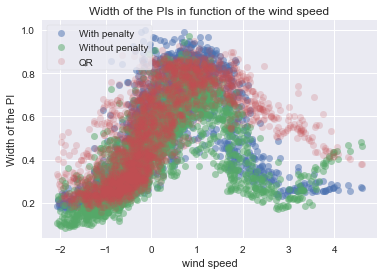

In [167]:
broad = U_alpha- L_alpha
broad_NP = U_alpha_NP- L_alpha_NP
broad_QR = Y_hat_Q2_v[:,n_farm] - Y_hat_Q1_v[:,n_farm]

plt.figure()
plt.plot(validation["ws4_"+str(n_farm+1)].values,broad,'o',label="With penalty",alpha=0.5)
plt.plot(validation["ws4_"+str(n_farm+1)].values,broad_NP,'o',label="Without penalty",alpha=0.5)
plt.plot(validation["ws4_"+str(n_farm+1)].values,broad_QR,'o',label="QR",alpha=0.2)
plt.xlabel("wind speed")
plt.ylabel("Width of the PI")
plt.title("Width of the PIs in function of the wind speed")
plt.legend(loc="upper left",frameon=True)
plt.show()

As the figure above shows, the width of the PIs for all three approaches tends to increase for "medium" values of wind speed. This is relevant to the nature of the data, where due to the bad nature of many wind speed forecasts multiple possible production values are associated.

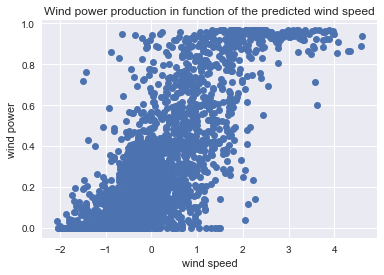

In [163]:
plt.figure()
plt.plot(validation["ws4_"+str(n_farm+1)].values,validation["wp_"+str(n_farm+1)].values,'o')
plt.title("Wind power production in function of the predicted wind speed")
plt.xlabel("wind speed")
plt.ylabel("wind power")
plt.show()

## Simulation results on the 7 wind farms

In order to tone down the randomness due to weights initialization in the NNs, the estimation procedure is repeated $B=10$ times for every farm and every level of confidence. The average of the previously introduced metrics are then taken. The initials "NP" (non-penalized) refer to the GMDN approach without reciprocal penalization.

In [156]:
#col_order = ["Farm","PICP","ACE","Score","Score_med","Score_xtr","Perc_xtr","Sharpness","Std_ACE","Std_Score"]
col_order1 = ["Farm","PICP","ACE","Score","Score_med","Sharpness"]
col_order2 = ["PICP","ACE","Score","Score_med","Sharpness"]

#print("For a 99% PI with penalization")
#display(bootstrap_PI_99_e[col_order1])
#display(bootstrap_PI_99_QR_e[col_order1])

## Level 99%

<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "7"><font size="5"><center> Penalized GMDN </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <th>Farm</th>
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.988813</td>
      <td>-0.001187</td>
      <td>-0.014998</td>
      <td>-0.011150</td>
      <td>0.553178</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.973212</td>
      <td>-0.016788</td>
      <td>-0.020878</td>
      <td>-0.011638</td>
      <td>0.613031</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.990030</td>
      <td>0.000030</td>
      <td>-0.016999</td>
      <td>-0.012670</td>
      <td>0.653357</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.984399</td>
      <td>-0.005601</td>
      <td>-0.018611</td>
      <td>-0.010923</td>
      <td>0.557361</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.984247</td>
      <td>-0.005753</td>
      <td>-0.018411</td>
      <td>-0.009916</td>
      <td>0.563444</td>
    </tr>
    <tr>
      <th>5</th>
      <td>0.989422</td>
      <td>-0.000578</td>
      <td>-0.014605</td>
      <td>-0.010155</td>
      <td>0.538946</td>
    </tr>
    <tr>
      <th>6</th>
      <td>0.979604</td>
      <td>-0.010396</td>
      <td>-0.018697</td>
      <td>-0.010341</td>
      <td>0.538609</td>
    </tr>
  </tbody>
</table> </td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "7"><font size="5"><center>Benchmark </center></size></th>
     </tr>
     
    <tr style="text-align: center;">
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.990487</td>
      <td>0.000487</td>
      <td>-0.014612</td>
      <td>-0.011605</td>
      <td>0.582756</td>
    </tr>
    <tr>
      <td>0.967656</td>
      <td>-0.022344</td>
      <td>-0.023609</td>
      <td>-0.011891</td>
      <td>0.615092</td>
    </tr>
    <tr>
      <td>0.988077</td>
      <td>-0.001923</td>
      <td>-0.019559</td>
      <td>-0.014817</td>
      <td>0.733437</td>
    </tr>
    <tr>
      <td>0.981989</td>
      <td>-0.008011</td>
      <td>-0.019708</td>
      <td>-0.013010</td>
      <td>0.669730</td>
    </tr>
    <tr>
      <td>0.986428</td>
      <td>-0.003572</td>
      <td>-0.015972</td>
      <td>-0.012525</td>
      <td>0.643695</td>
    </tr>
    <tr>
      <td>0.994039</td>
      <td>0.004039</td>
      <td>-0.015315</td>
      <td>-0.011869</td>
      <td>0.621707</td>
    </tr>
    <tr>
      <td>0.981355</td>
      <td>-0.008645</td>
      <td>-0.020707</td>
      <td>-0.011116</td>
      <td>0.621119</td>
    </tr>
  </tbody>
</table> </td>

</table>


<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "7"><font size="5"><center> NP GMDN </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <th>Farm</th>
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.976712</td>
      <td>-0.013288</td>
      <td>-0.017391</td>
      <td>-0.010112</td>
      <td>0.495240</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.951065</td>
      <td>-0.038935</td>
      <td>-0.031720</td>
      <td>-0.010780</td>
      <td>0.576498</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.969635</td>
      <td>-0.020365</td>
      <td>-0.022239</td>
      <td>-0.011584</td>
      <td>0.581767</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.981887</td>
      <td>-0.008113</td>
      <td>-0.017943</td>
      <td>-0.010382</td>
      <td>0.551807</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.971233</td>
      <td>-0.018767</td>
      <td>-0.023329</td>
      <td>-0.009863</td>
      <td>0.556341</td>
    </tr>
    <tr>
      <th>5</th>
      <td>0.974734</td>
      <td>-0.015266</td>
      <td>-0.017369</td>
      <td>-0.009330</td>
      <td>0.495060</td>
    </tr>
    <tr>
      <th>6</th>
      <td>0.964916</td>
      <td>-0.025084</td>
      <td>-0.023600</td>
      <td>-0.009517</td>
      <td>0.498213</td>
    </tr>
  </tbody>
</table> </td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "7"><font size="5"><center>Benchmark </center></size></th>
     </tr>
     
    <tr style="text-align: center;">
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.990487</td>
      <td>0.000487</td>
      <td>-0.014612</td>
      <td>-0.011605</td>
      <td>0.582756</td>
    </tr>
    <tr>
      <td>0.967656</td>
      <td>-0.022344</td>
      <td>-0.023609</td>
      <td>-0.011891</td>
      <td>0.615092</td>
    </tr>
    <tr>
      <td>0.988077</td>
      <td>-0.001923</td>
      <td>-0.019559</td>
      <td>-0.014817</td>
      <td>0.733437</td>
    </tr>
    <tr>
      <td>0.981989</td>
      <td>-0.008011</td>
      <td>-0.019708</td>
      <td>-0.013010</td>
      <td>0.669730</td>
    </tr>
    <tr>
      <td>0.986428</td>
      <td>-0.003572</td>
      <td>-0.015972</td>
      <td>-0.012525</td>
      <td>0.643695</td>
    </tr>
    <tr>
      <td>0.994039</td>
      <td>0.004039</td>
      <td>-0.015315</td>
      <td>-0.011869</td>
      <td>0.621707</td>
    </tr>
    <tr>
      <td>0.981355</td>
      <td>-0.008645</td>
      <td>-0.020707</td>
      <td>-0.011116</td>
      <td>0.621119</td>
    </tr>
  </tbody>
</table> </td>

</table>

## Level 95%

<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "7"><font size="5"><center> Penalized GMDN </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <th>Farm</th>
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.957002</td>
      <td>0.007002</td>
      <td>-0.056812</td>
      <td>-0.044564</td>
      <td>0.427695</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.928691</td>
      <td>-0.021309</td>
      <td>-0.080779</td>
      <td>-0.049558</td>
      <td>0.504871</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.955860</td>
      <td>0.005860</td>
      <td>-0.068871</td>
      <td>-0.048992</td>
      <td>0.505393</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.957230</td>
      <td>0.007230</td>
      <td>-0.062107</td>
      <td>-0.045539</td>
      <td>0.452047</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.945129</td>
      <td>-0.004871</td>
      <td>-0.068471</td>
      <td>-0.039534</td>
      <td>0.447688</td>
    </tr>
    <tr>
      <th>5</th>
      <td>0.953957</td>
      <td>0.003957</td>
      <td>-0.056467</td>
      <td>-0.042373</td>
      <td>0.431232</td>
    </tr>
    <tr>
      <th>6</th>
      <td>0.947336</td>
      <td>-0.002664</td>
      <td>-0.065405</td>
      <td>-0.043060</td>
      <td>0.449221</td>
    </tr>
  </tbody>
</table> </td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "7"><font size="5"><center>Benchmark </center></size></th>
     </tr>
     
    <tr style="text-align: center;">
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.958270</td>
      <td>0.008270</td>
      <td>-0.059905</td>
      <td>-0.048523</td>
      <td>0.465216</td>
    </tr>
    <tr>
      <td>0.880391</td>
      <td>-0.069609</td>
      <td>-0.080862</td>
      <td>-0.050269</td>
      <td>0.502251</td>
    </tr>
    <tr>
      <td>0.955353</td>
      <td>0.005353</td>
      <td>-0.072729</td>
      <td>-0.055517</td>
      <td>0.544974</td>
    </tr>
    <tr>
      <td>0.961695</td>
      <td>0.011695</td>
      <td>-0.063160</td>
      <td>-0.048996</td>
      <td>0.498074</td>
    </tr>
    <tr>
      <td>0.914637</td>
      <td>-0.035363</td>
      <td>-0.066646</td>
      <td>-0.047179</td>
      <td>0.501220</td>
    </tr>
    <tr>
      <td>0.951801</td>
      <td>0.001801</td>
      <td>-0.060152</td>
      <td>-0.043366</td>
      <td>0.474382</td>
    </tr>
    <tr>
      <td>0.935185</td>
      <td>-0.014815</td>
      <td>-0.070847</td>
      <td>-0.041854</td>
      <td>0.455786</td>
    </tr>
  </tbody>
</table> </td>

</table>


<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "7"><font size="5"><center> NP GMDN </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <th>Farm</th>
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.926788</td>
      <td>-0.023212</td>
      <td>-0.060017</td>
      <td>-0.042079</td>
      <td>0.385387</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.873820</td>
      <td>-0.076180</td>
      <td>-0.096283</td>
      <td>-0.044904</td>
      <td>0.440905</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.902892</td>
      <td>-0.047108</td>
      <td>-0.075459</td>
      <td>-0.048167</td>
      <td>0.456786</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.917352</td>
      <td>-0.032648</td>
      <td>-0.067400</td>
      <td>-0.042564</td>
      <td>0.394536</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.907534</td>
      <td>-0.042466</td>
      <td>-0.077257</td>
      <td>-0.038575</td>
      <td>0.402800</td>
    </tr>
    <tr>
      <th>5</th>
      <td>0.899087</td>
      <td>-0.050913</td>
      <td>-0.062582</td>
      <td>-0.038626</td>
      <td>0.369054</td>
    </tr>
    <tr>
      <th>6</th>
      <td>0.894901</td>
      <td>-0.055099</td>
      <td>-0.075994</td>
      <td>-0.039056</td>
      <td>0.366816</td>
    </tr>
  </tbody>
</table> </td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "7"><font size="5"><center>Benchmark </center></size></th>
     </tr>
     
    <tr style="text-align: center;">
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.958270</td>
      <td>0.008270</td>
      <td>-0.059905</td>
      <td>-0.048523</td>
      <td>0.465216</td>
    </tr>
    <tr>
      <td>0.880391</td>
      <td>-0.069609</td>
      <td>-0.080862</td>
      <td>-0.050269</td>
      <td>0.502251</td>
    </tr>
    <tr>
      <td>0.955353</td>
      <td>0.005353</td>
      <td>-0.072729</td>
      <td>-0.055517</td>
      <td>0.544974</td>
    </tr>
    <tr>
      <td>0.961695</td>
      <td>0.011695</td>
      <td>-0.063160</td>
      <td>-0.048996</td>
      <td>0.498074</td>
    </tr>
    <tr>
      <td>0.914637</td>
      <td>-0.035363</td>
      <td>-0.066646</td>
      <td>-0.047179</td>
      <td>0.501220</td>
    </tr>
    <tr>
      <td>0.951801</td>
      <td>0.001801</td>
      <td>-0.060152</td>
      <td>-0.043366</td>
      <td>0.474382</td>
    </tr>
    <tr>
      <td>0.935185</td>
      <td>-0.014815</td>
      <td>-0.070847</td>
      <td>-0.041854</td>
      <td>0.455786</td>
    </tr>
  </tbody>
</table> </td>

</table>

## Level 90%

<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "7"><font size="5"><center> Penalized GMDN </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <th>Farm</th>
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
 <tbody>
    <tr>
      <th>0</th>
      <td>0.903577</td>
      <td>0.003577</td>
      <td>-0.100698</td>
      <td>-0.077876</td>
      <td>0.351399</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.859437</td>
      <td>-0.040563</td>
      <td>-0.146930</td>
      <td>-0.085992</td>
      <td>0.401444</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.912405</td>
      <td>0.012405</td>
      <td>-0.120695</td>
      <td>-0.086915</td>
      <td>0.429447</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.916819</td>
      <td>0.016819</td>
      <td>-0.107541</td>
      <td>-0.080707</td>
      <td>0.377709</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.887900</td>
      <td>-0.012100</td>
      <td>-0.122201</td>
      <td>-0.066389</td>
      <td>0.346033</td>
    </tr>
    <tr>
      <th>5</th>
      <td>0.891629</td>
      <td>-0.008371</td>
      <td>-0.101012</td>
      <td>-0.073745</td>
      <td>0.349206</td>
    </tr>
    <tr>
      <th>6</th>
      <td>0.909056</td>
      <td>0.009056</td>
      <td>-0.113931</td>
      <td>-0.074767</td>
      <td>0.365286</td>
    </tr>
  </tbody>
</table> </td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "7"><font size="5"><center>Benchmark </center></size></th>
     </tr>
     
    <tr style="text-align: center;">
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
 <tbody>
    <tr>
      <td>0.877220</td>
      <td>-0.022780</td>
      <td>-0.108575</td>
      <td>-0.084451</td>
      <td>0.401607</td>
    </tr>
    <tr>
      <td>0.832192</td>
      <td>-0.067808</td>
      <td>-0.137456</td>
      <td>-0.090913</td>
      <td>0.430567</td>
    </tr>
    <tr>
      <td>0.890284</td>
      <td>-0.009716</td>
      <td>-0.128882</td>
      <td>-0.095621</td>
      <td>0.453755</td>
    </tr>
    <tr>
      <td>0.909310</td>
      <td>0.009310</td>
      <td>-0.110772</td>
      <td>-0.090934</td>
      <td>0.459537</td>
    </tr>
    <tr>
      <td>0.907915</td>
      <td>0.007915</td>
      <td>-0.122724</td>
      <td>-0.075504</td>
      <td>0.423335</td>
    </tr>
    <tr>
      <td>0.912227</td>
      <td>0.012227</td>
      <td>-0.099985</td>
      <td>-0.077963</td>
      <td>0.385590</td>
    </tr>
    <tr>
      <td>0.890411</td>
      <td>-0.009589</td>
      <td>-0.124283</td>
      <td>-0.080572</td>
      <td>0.403964</td>
    </tr>
  </tbody>
</table> </td>

</table>


<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "7"><font size="5"><center> NP GMDN </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <th>Farm</th>
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.869178</td>
      <td>-0.030822</td>
      <td>-0.102722</td>
      <td>-0.075557</td>
      <td>0.328433</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.784170</td>
      <td>-0.115830</td>
      <td>-0.156076</td>
      <td>-0.081396</td>
      <td>0.368780</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.836606</td>
      <td>-0.063394</td>
      <td>-0.127490</td>
      <td>-0.086506</td>
      <td>0.384879</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.844597</td>
      <td>-0.055403</td>
      <td>-0.113262</td>
      <td>-0.076294</td>
      <td>0.327491</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.834703</td>
      <td>-0.065297</td>
      <td>-0.128229</td>
      <td>-0.068232</td>
      <td>0.320205</td>
    </tr>
    <tr>
      <th>5</th>
      <td>0.811416</td>
      <td>-0.088584</td>
      <td>-0.107275</td>
      <td>-0.070347</td>
      <td>0.310510</td>
    </tr>
    <tr>
      <th>6</th>
      <td>0.825190</td>
      <td>-0.074810</td>
      <td>-0.121680</td>
      <td>-0.069235</td>
      <td>0.307496</td>
    </tr>
  </tbody>
</table> </td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "7"><font size="5"><center>Benchmark </center></size></th>
     </tr>
     
    <tr style="text-align: center;">
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  
<tbody>
    <tr>
      <td>0.877220</td>
      <td>-0.022780</td>
      <td>-0.108575</td>
      <td>-0.084451</td>
      <td>0.401607</td>
    </tr>
    <tr>
      <td>0.832192</td>
      <td>-0.067808</td>
      <td>-0.137456</td>
      <td>-0.090913</td>
      <td>0.430567</td>
    </tr>
    <tr>
      <td>0.890284</td>
      <td>-0.009716</td>
      <td>-0.128882</td>
      <td>-0.095621</td>
      <td>0.453755</td>
    </tr>
    <tr>
      <td>0.909310</td>
      <td>0.009310</td>
      <td>-0.110772</td>
      <td>-0.090934</td>
      <td>0.459537</td>
    </tr>
    <tr>
      <td>0.907915</td>
      <td>0.007915</td>
      <td>-0.122724</td>
      <td>-0.075504</td>
      <td>0.423335</td>
    </tr>
    <tr>
      <td>0.912227</td>
      <td>0.012227</td>
      <td>-0.099985</td>
      <td>-0.077963</td>
      <td>0.385590</td>
    </tr>
    <tr>
      <td>0.890411</td>
      <td>-0.009589</td>
      <td>-0.124283</td>
      <td>-0.080572</td>
      <td>0.403964</td>
    </tr>
  </tbody></table> </td>

</table>

## Level 80%

<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "7"><font size="5"><center> Penalized GMDN </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <th>Farm</th>
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
 <tbody>
    <tr>
      <th>0</th>
      <td>0.813166</td>
      <td>0.013166</td>
      <td>-0.169128</td>
      <td>-0.130805</td>
      <td>0.276884</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.780061</td>
      <td>-0.019939</td>
      <td>-0.236223</td>
      <td>-0.151356</td>
      <td>0.331749</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.809361</td>
      <td>0.009361</td>
      <td>-0.204019</td>
      <td>-0.146614</td>
      <td>0.333932</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.836986</td>
      <td>0.036986</td>
      <td>-0.178506</td>
      <td>-0.140642</td>
      <td>0.301151</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.797565</td>
      <td>-0.002435</td>
      <td>-0.198453</td>
      <td>-0.116963</td>
      <td>0.271300</td>
    </tr>
    <tr>
      <th>5</th>
      <td>0.796499</td>
      <td>-0.003501</td>
      <td>-0.173612</td>
      <td>-0.124263</td>
      <td>0.278767</td>
    </tr>
    <tr>
      <th>6</th>
      <td>0.824962</td>
      <td>0.024962</td>
      <td>-0.184568</td>
      <td>-0.123780</td>
      <td>0.279283</td>
    </tr>
  </tbody>
</table> </td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "7"><font size="5"><center>Benchmark </center></size></th>
     </tr>
     
    <tr style="text-align: center;">
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
<tbody>
    <tr>
      <td>0.826484</td>
      <td>0.026484</td>
      <td>-0.181914</td>
      <td>-0.132341</td>
      <td>0.309612</td>
    </tr>
    <tr>
      <td>0.747844</td>
      <td>-0.052156</td>
      <td>-0.242836</td>
      <td>-0.145125</td>
      <td>0.315892</td>
    </tr>
    <tr>
      <td>0.806824</td>
      <td>0.006824</td>
      <td>-0.212134</td>
      <td>-0.152488</td>
      <td>0.348570</td>
    </tr>
    <tr>
      <td>0.768519</td>
      <td>-0.031481</td>
      <td>-0.187999</td>
      <td>-0.140195</td>
      <td>0.338172</td>
    </tr>
    <tr>
      <td>0.791730</td>
      <td>-0.008270</td>
      <td>-0.202515</td>
      <td>-0.123722</td>
      <td>0.293745</td>
    </tr>
    <tr>
      <td>0.802004</td>
      <td>0.002004</td>
      <td>-0.180093</td>
      <td>-0.129432</td>
      <td>0.297356</td>
    </tr>
    <tr>
      <td>0.809361</td>
      <td>0.009361</td>
      <td>-0.200459</td>
      <td>-0.141047</td>
      <td>0.310790</td>
    </tr>
  </tbody>
</table> </td>

</table>


<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "7"><font size="5"><center> NP GMDN </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <th>Farm</th>
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.754110</td>
      <td>-0.045890</td>
      <td>-0.170971</td>
      <td>-0.126040</td>
      <td>0.259675</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.635160</td>
      <td>-0.164840</td>
      <td>-0.248932</td>
      <td>-0.139670</td>
      <td>0.282990</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.717580</td>
      <td>-0.082420</td>
      <td>-0.209943</td>
      <td>-0.145686</td>
      <td>0.302139</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.716438</td>
      <td>-0.083562</td>
      <td>-0.184448</td>
      <td>-0.126446</td>
      <td>0.253700</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.713166</td>
      <td>-0.086834</td>
      <td>-0.205785</td>
      <td>-0.113201</td>
      <td>0.238315</td>
    </tr>
    <tr>
      <th>5</th>
      <td>0.678463</td>
      <td>-0.121537</td>
      <td>-0.178425</td>
      <td>-0.118274</td>
      <td>0.243209</td>
    </tr>
    <tr>
      <th>6</th>
      <td>0.686530</td>
      <td>-0.113470</td>
      <td>-0.191806</td>
      <td>-0.114448</td>
      <td>0.236971</td>
    </tr>
  </tbody>
</table> </td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "7"><font size="5"><center>Benchmark </center></size></th>
     </tr>
     
    <tr style="text-align: center;">
      <th>PICP</th>
      <th>ACE</th>
      <th>Score</th>
      <th>Score_med</th>
      <th>Sharpness</th>
    </tr>
  </thead>
  
<tbody>
    <tr>
      <td>0.826484</td>
      <td>0.026484</td>
      <td>-0.181914</td>
      <td>-0.132341</td>
      <td>0.309612</td>
    </tr>
    <tr>
      <td>0.747844</td>
      <td>-0.052156</td>
      <td>-0.242836</td>
      <td>-0.145125</td>
      <td>0.315892</td>
    </tr>
    <tr>
      <td>0.806824</td>
      <td>0.006824</td>
      <td>-0.212134</td>
      <td>-0.152488</td>
      <td>0.348570</td>
    </tr>
    <tr>
      <td>0.768519</td>
      <td>-0.031481</td>
      <td>-0.187999</td>
      <td>-0.140195</td>
      <td>0.338172</td>
    </tr>
    <tr>
      <td>0.791730</td>
      <td>-0.008270</td>
      <td>-0.202515</td>
      <td>-0.123722</td>
      <td>0.293745</td>
    </tr>
    <tr>
      <td>0.802004</td>
      <td>0.002004</td>
      <td>-0.180093</td>
      <td>-0.129432</td>
      <td>0.297356</td>
    </tr>
    <tr>
      <td>0.809361</td>
      <td>0.009361</td>
      <td>-0.200459</td>
      <td>-0.141047</td>
      <td>0.310790</td>
    </tr>
  </tbody></table> </td>

</table>

PICP values for every level $1-\alpha$ are always very close to their theoretical value with reciprocal penalization, but below up to 16% without it. The comparison between the benchmark and the proposed approach shows that the PICP and scores are very similar. However the penalized GMDN usually yields sharper intervals. In terms of median score the GMDN method yields almost always better values, emphasizing the fact that the increase of skill score is usually due to extremely bad outliers which are not numerous (usually below the $\alpha$ % of data not covered by the PI).

Hereafter one may find a graphical representation of the previously presented tables for the level 95% for convenience.

In [82]:
trace0 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_e["PICP"],
    name='GMDN Penal',
    marker=dict(
        color='rgb(49,130,189)'
    )
)

trace1 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_QR_e["PICP"],
    name='QR',
    marker=dict(
        color='rgb(130,49,189)'
    )
)
                        
trace2 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_NP_e["PICP"],
    name='GMDN NP',
    marker=dict(
        color='rgb(130,189,49)'
    )
)
                        
data = [trace0,trace1,trace2]
layout = go.Layout(
    barmode='group',
    title="PICP for each farm for the level "+str(int(100*(1-alpha))) + "%"
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [81]:
trace0 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_e["Sharpness"],
    name='GMDN Penal',
    marker=dict(
        color='rgb(49,130,189)'
    )
)

trace1 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_QR_e["Sharpness"],
    name='QR',
    marker=dict(
        color='rgb(130,49,189)'
    )
)

trace2 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_NP_e["Sharpness"],
    name='GMDN NP',
    marker=dict(
        color='rgb(130,189,49)'
    )
)
                        
data = [trace0,trace1,trace2]
layout = go.Layout(
    barmode='group',
    title="Sharpness farm for the level "+str(int(100*(1-alpha))) + "%"
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [85]:
trace0 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_e["Score"],
    name='GMDN Penal',
    marker=dict(
        color='rgb(49,130,189)'
    )
)

trace1 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_QR_e["Score"],
    name='QR',
    marker=dict(
        color='rgb(130,49,189)'
    )
)

trace2 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_NP_e["Score"],
    name='GMDN NP',
    marker=dict(
        color='rgb(130,189,49)'
    )
)
                        
data = [trace0,trace1,trace2]
                        
layout = go.Layout(
    barmode='group',
    title="Score for each farm for the level "+str(int(100*(1-alpha))) + "%"
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [86]:
trace0 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_e["Score_med"],
    name='GMDN Penal',
    marker=dict(
        color='rgb(49,130,189)'
    )
)

trace1 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_QR_e["Score_med"],
    name='QR',
    marker=dict(
        color='rgb(130,49,189)'
    )
)

trace2 = go.Bar(
    x=["Farm "+str(k) for k in range(1,8)],
    y=bootstrap_PI_95_NP_e["Score_med"],
    name='GMDN NP',
    marker=dict(
        color='rgb(130,189,49)'
    )
)
                        
data = [trace0,trace1,trace2]
                        
layout = go.Layout(
    barmode='group',
    title="Median score for each farm for the level "+str(int(100*(1-alpha))) + "%"
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

The difference in terms of skill score between the benchmark and the GMDN approach is so small due to large outliers which inflate the value of the metric. This can be seen by plotting either the score for every individual sample or with a boxplot. Hereafter those are given for $\alpha = 0.05$ and for a given wind farm as example. 

In [128]:
score_vec_pena = score_vec(Y_e[:,n_farm],L_alpha_e,U_alpha_e,alpha)
score_vec_QR = score_vec(Y_e[:,n_farm],Y_hat_Q1[:,n_farm],Y_hat_Q2[:,n_farm],alpha)

trace0 = go.Scatter(
    #x=evaluation.date,
    y=score_vec_pena,
    fill= None,
    mode='lines',
    line=dict(
        color='rgb(187, 247, 172)',
    
    ),
    name="GMDN Penal"
)
trace1 = go.Scatter(
    #x=evaluation.date,
    y=score_vec_QR,
    fill=None,
    mode='lines',
    line=dict(
        color='rgb(247, 187, 172)',
    ),
    name="QR"
)

layout = go.Layout(
    title='Individual score for every instant for the level ' +str(int(100*(1-alpha)))+'% for a single farm',
    xaxis=dict(
        title='t',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Score',
        titlefont=dict(
           # family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
    
data = [trace0, trace1]
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

C:\Users\David\Anaconda3\envs\edward\lib\site-packages\matplotlib\figure.py:403: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



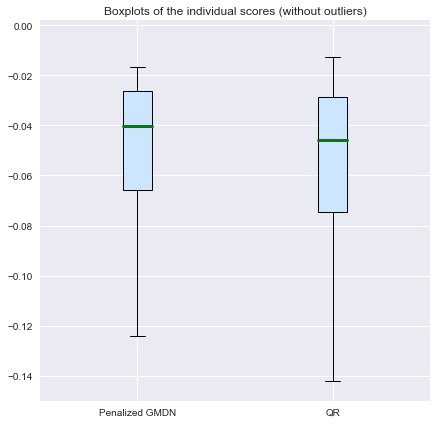

In [126]:
fig = plt.figure(1,figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_ylim(-0.15,0.002)
bp = ax.boxplot([score_vec_pena,score_vec_QR],patch_artist=True)

for box in bp['boxes']:
    # change outline color
    #box.set( color='blue', linewidth=2)
    # change fill color
    box.set( facecolor = '#cce6ff' )
    
for median in bp['medians']:
    median.set(color='#008000', linewidth=3)

ax.set_xticklabels(['Penalized GMDN','QR'])
plt.title("Boxplots of the individual scores (without outliers)")
fig.show()

# Summary of the advantages and drawbacks of the GMDN approach

Considering the results presented here, the gaussian mixture density network approach may be interesting for real-life application for stochastic energy producers or the network operator. While in terms of pure skill score it does not always beat the benchmark, it yields PIs which are narrower than QR and with a lower median score. This means that the system operator will have a better knowledge of what the future production will be, with only a minimalistic risk of being off. To be more precise, simulations show that the percentage of "extreme outliers" which inflate the skill score is generally within the $\alpha$% of data not covered by the prediction interval, which makes the risk associated with the GMDN method acceptable to take.

To summarize it, here are the main advantages and drawbacks of the developed approach:

**Advantages:**
* No need for any hypothesis on the residuals.
* Computationally cheaper than bootstrap.
* No modelization of model misspecification or noise needed.
* Yields narrower PIs than its rivals with equal PICP.
* Easy tuning.

**Drawbacks**
* Needs the tuning of a NN and a penalty parameter $\lambda$ (although tuning the NN seems not to be crucial).
* Gives too narrow PIs without penalization.
* Sometimes beaten in terms of traditional skill score by QR due to extreme outliers.
* The backprop sometimes has issues to converge with too many inputs or if the number of hidden neurons is significant.

## Further possibilities

* For correlated wind farms, jointly estimating the PIs for the wind farms (needs the estimation of a covariance matrix and thus has an increased computational cost) may lead to even better results.